# Catch 4 Critters EEG - ERP analysis

In [1]:
# Import relevant packages
import os
import numpy as np
import mne
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
import glm

ModuleNotFoundError: No module named 'glm'

In [2]:
# Define data file locations etc
homeDir = '/Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/'
os.chdir(homeDir)

# set montage file
montage = homeDir + "montage/m.elp"
subjects = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14',
           'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 
            'S29', 'S30'] # Only analyzing 18-30 for now
filename = 'dataClean-epo.fif'

#filenames = ['','' ,'' ,'','', '','' ,'' ,'','', '','' ,'' ,'','', '', '', 'testClean-epo.fif', 'testClean-epo.fif','testClean-epo.fif', 'testClean-epo.fif',
#            'testClean-epo.fif', 'testClean-epo.fif','testClean-epo.fif', 'testClean-epo.fif','testClean-epo.fif', 'testClean-epo.fif','testClean-epo.fif', 'testClean-epo.fif',
            #'testClean-epo.fif', 'testClean-epo.fif','testClean-epo.fif', 'testClean-epo.fif','testClean-epo.fif', 'testClean-epo.fif']

In [9]:
# load data
#subs = [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30]
# or all subs
reref = True
subs = [1, 3, 4, 6,7,9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,26, 27, 29, 30]

evokedL_dictAll= dict()
evokedO_dictAll= dict()

for i in subs:
    subInd = i - 1
    
    
    evokedL_dict= dict()
    evokedO_dict= dict()

    #load data
    datafile = os.path.join(homeDir, subjects[subInd], filename)
    epochs = mne.read_epochs(datafile, preload=True)
    
    if reref:
        epochs = mne.preprocessing.compute_current_source_density(epochs)
    
    # Filter
    epochs.filter(None,20, picks = 'all', fir_design = 'firwin')
    
    # Separate different conditions 
    indO = epochs.metadata['blockType'] == 'Orienting'
    indL = (epochs.metadata['blockType'] == 'Learning') # take only trials with at least one exposure
    indEarly = epochs.metadata['Delay'] < 2300
    indLate = epochs.metadata['Delay'] > 2300
    indRand = epochs.metadata['Condition'] == 'random'
    indPred = epochs.metadata['Condition'] == 'predicted'
    indLeft = epochs.metadata['TargetX'] < 0
    indRight = epochs.metadata['TargetX'] > 0
    indLeft1 = epochs.metadata['target1X'] < 0
    indRight1 = epochs.metadata['target1X'] > 0
    indRespL = epochs.metadata['Answer'] < 6
    indRespR = epochs.metadata['Answer'] > 5
    indCorrect = epochs.metadata['correct'] == 1
    indnRep1 = epochs.metadata['nRep'] == 1
    indnRep2 = epochs.metadata['nRep'] == 2
    indnRep3 = epochs.metadata['nRep'] == 3
    indnRep4 = epochs.metadata['nRep'] == 4
    indnRep5 = epochs.metadata['nRep'] == 5
    indnRep6 = epochs.metadata['nRep'] == 6
    indnRep = epochs.metadata['nRep'] > 1
    indRespCorrL = epochs.metadata['TargetCorrectButton'] <3.0
    indRespCorrR = epochs.metadata['TargetCorrectButton'] > 2.0
    
    
    
    # separate conditions by place of visual target
    evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
    evokedO_dict['Early/Random/Right'] = epochs[indO*indEarly*indRand*indRight].average()
    evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average()
    evokedO_dict['Late/Random/Right'] = epochs[indO*indLate*indRand*indRight].average()
    evokedO_dict['Early/Predicted/Left'] = epochs[indO*indEarly*indPred*indLeft].average()
    evokedO_dict['Early/Predicted/Right'] = epochs[indO*indEarly*indPred*indRight].average()
    evokedO_dict['Late/Predicted/Left'] = epochs[indO*indLate*indPred*indLeft].average()
    evokedO_dict['Late/Predicted/Right'] =epochs[indO*indLate*indPred*indRight].average()
    
    # Separate random/predicted and early/late only
    evokedO_dict['Early/Random'] = epochs[indO*indEarly*indRand].average()
    evokedO_dict['Late/Random'] = epochs[indO*indLate*indRand].average()
    evokedO_dict['Early/Predicted'] = epochs[indO*indEarly*indPred].average()
    evokedO_dict['Late/Predicted'] = epochs[indO*indLate*indPred].average()
    
    # collapse over early/late
    evokedO_dict['Random/Left'] = epochs[np.logical_or(indO&indEarly&indRand&indLeft, indO&indLate&indRand&indRight) ].average()
    evokedO_dict['Random/Right'] = epochs[np.logical_or(indO&indEarly&indRand&indRight, indO&indLate&indRand&indLeft)].average()
    evokedO_dict['Predicted/Left'] = epochs[np.logical_or(indO&indEarly&indPred&indLeft, indO&indLate&indPred&indRight) ].average()
    evokedO_dict['Predicted/Right'] = epochs[np.logical_or(indO&indEarly&indPred&indRight, indO&indLate&indPred&indLeft )].average()
    
    
    # Separate by left/right hand response
    evokedO_dict['Early/Random/RespLeft'] = epochs[indO*indEarly*indRand*indRespL].average()
    evokedO_dict['Early/Random/RespRight'] = epochs[indO*indEarly*indRand*indRespR].average()
    evokedO_dict['Late/Random/RespLeft'] = epochs[indO*indLate*indRand*indRespL].average()
    evokedO_dict['Late/Random/RespRight'] = epochs[indO*indLate*indRand*indRespR].average()
    evokedO_dict['Early/Predicted/RespLeft'] = epochs[indO*indEarly*indPred*indRespL].average()
    evokedO_dict['Early/Predicted/RespRight'] = epochs[indO*indEarly*indPred*indRespR].average()
    evokedO_dict['Late/Predicted/RespLeft'] = epochs[indO*indLate*indPred*indRespL].average()
    evokedO_dict['Late/Predicted/RespRight'] =epochs[indO*indLate*indPred*indRespR].average()
    
    # Separate by left/right hand response -- correct response i.e. expected hand resp
    evokedO_dict['Early/Random/RespLeftC'] = epochs[indO*indEarly*indRand*indRespCorrL].average()
    evokedO_dict['Early/Random/RespRightC'] = epochs[indO*indEarly*indRand*indRespCorrR].average()
    evokedO_dict['Late/Random/RespLeftC'] = epochs[indO*indLate*indRand*indRespCorrL].average()
    evokedO_dict['Late/Random/RespRightC'] = epochs[indO*indLate*indRand*indRespCorrR].average()
    evokedO_dict['Early/Predicted/RespLeftC'] = epochs[indO*indEarly*indPred*indRespCorrL].average()
    evokedO_dict['Early/Predicted/RespRightC'] = epochs[indO*indEarly*indPred*indRespCorrR].average()
    evokedO_dict['Late/Predicted/RespLeftC'] = epochs[indO*indLate*indPred*indRespCorrL].average()
    evokedO_dict['Late/Predicted/RespRightC'] =epochs[indO*indLate*indPred*indRespCorrR].average()
    
    evokedL_dict['Random/Left'] = epochs[indL*indRand*indLeft1].average() # Left animal first
    evokedL_dict['Random/Right'] = epochs[indL*indRand*indRight1].average()
    evokedL_dict['Predicted/Left'] = epochs[indL*indPred*indLeft1].average() # Left animal first
    evokedL_dict['Predicted/Right'] = epochs[indL*indPred*indRight1].average()
    
    evokedL_dict['Random'] = epochs[indL*indRand*indnRep].average()
    evokedL_dict['Predicted'] = epochs[indL*indPred*indnRep].average() 
    
    evokedL_dict['Random/nRep1'] = epochs[indL*indRand*indnRep1].average()
    evokedL_dict['Predicted/nRep1'] = epochs[indL*indPred*indnRep1].average() 
    evokedL_dict['Random/nRep2'] = epochs[indL*indRand*indnRep2].average()
    evokedL_dict['Predicted/nRep2'] = epochs[indL*indPred*indnRep2].average() 
    evokedL_dict['Random/nRep3'] = epochs[indL*indRand*indnRep3].average()
    evokedL_dict['Predicted/nRep3'] = epochs[indL*indPred*indnRep3].average()
    evokedL_dict['Random/nRep4'] = epochs[indL*indRand*indnRep4].average()
    evokedL_dict['Predicted/nRep4'] = epochs[indL*indPred*indnRep4].average() 
    evokedL_dict['Random/nRep5'] = epochs[indL*indRand*indnRep5].average()
    evokedL_dict['Predicted/nRep5'] = epochs[indL*indPred*indnRep5].average() 
    evokedL_dict['Random/nRep6'] = epochs[indL*indRand*indnRep6].average()
    evokedL_dict['Predicted/nRep6'] = epochs[indL*indPred*indnRep6].average() 
    
    
    
    evokedO_dictAll['S' + str(i)] = evokedO_dict
    evokedL_dictAll['S' + str(i)] = evokedL_dict
    
    #indRandEarlyL = epochs.average()
   # indRandEarlyR = 
    #indRandLateL = 
   # indRandLateR = 
   # indPredEarlyL = 
   # indPredEarlyR = 
   # indPredLateL = 
   # indPredLateR = 
    
    

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S01/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S03/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
555 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S04/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
545 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S06/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S07/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
566 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S09/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
505 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S10/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
533 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S11/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
538 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S12/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
477 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S14/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
542 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S15/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
529 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S16/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
535 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S17/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-9-97927fb5098e>:54: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
<ipython-input-9-97927fb5098e>:56: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average(

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S18/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
534 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S19/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
568 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S20/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
525 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S21/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
531 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S22/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
545 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S23/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
536 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S24/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
555 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S25/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
555 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S26/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
557 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S27/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
553 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S29/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
560 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S30/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
542 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-9-97927fb5098e>:22: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epochs = mne.preprocessing.compute_current_source_density(epochs)


Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [6]:
# load data - correct trials only
#subs = [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30]

#subs = [1, 3, 4, 6,7, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30] 
# Left out 2 cause noisy, 5 (drift, big hair), 8 (thick hair, split file, combining files not implemented yet), 
# 9 (drift), 13(split file), 28 (split file)

subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30]

evokedL_dictAll= dict()
evokedO_dictAll= dict()

for i in subs:
    subInd = i - 1
    
    
    evokedL_dict= dict()
    evokedO_dict= dict()

    #load data
    datafile = os.path.join(homeDir, subjects[subInd], filename)
    epochs = mne.read_epochs(datafile, preload=True)
    #epochs = epochs.interpolate_bads()
    
    # Filter
    epochs.filter(None,20, picks = 'all', fir_design = 'firwin')
    
    # Separate different conditions 
    indO = epochs.metadata['blockType'] == 'Orienting'
    indL = (epochs.metadata['blockType'] == 'Learning') # take only trials with at least one exposure
    indEarly = epochs.metadata['Delay'] < 2300
    indLate = epochs.metadata['Delay'] > 2300
    indRand = epochs.metadata['Condition'] == 'random'
    indPred = epochs.metadata['Condition'] == 'predicted'
    indLeft = epochs.metadata['TargetX'] < 0
    indRight = epochs.metadata['TargetX'] > 0
    indLeft1 = epochs.metadata['target1X'] < 0
    indRight1 = epochs.metadata['target1X'] > 0
    indRespL = epochs.metadata['Answer'] < 6
    indRespR = epochs.metadata['Answer'] > 5
    indCorrect = epochs.metadata['correct'] == 1
    indnRep1 = epochs.metadata['nRep'] == 1
    indnRep2 = epochs.metadata['nRep'] == 2
    indnRep3 = epochs.metadata['nRep'] == 3
    indnRep4 = epochs.metadata['nRep'] == 4
    indnRep5 = epochs.metadata['nRep'] == 5
    indnRep6 = epochs.metadata['nRep'] == 6
    
    
    # separate conditions by place of visual target
    evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
    evokedO_dict['Early/Random/Right'] = epochs[indO*indEarly*indRand*indRight*indCorrect].average()
    evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()
    evokedO_dict['Late/Random/Right'] = epochs[indO*indLate*indRand*indRight*indCorrect].average()
    evokedO_dict['Early/Predicted/Left'] = epochs[indO*indEarly*indPred*indLeft*indCorrect].average()
    evokedO_dict['Early/Predicted/Right'] = epochs[indO*indEarly*indPred*indRight*indCorrect].average()
    evokedO_dict['Late/Predicted/Left'] = epochs[indO*indLate*indPred*indLeft*indCorrect].average()
    evokedO_dict['Late/Predicted/Right'] =epochs[indO*indLate*indPred*indRight*indCorrect].average()
    
    # Separate random/predicted and early/late only
    evokedO_dict['Early/Random'] = epochs[indO*indEarly*indRand*indCorrect].average()
    evokedO_dict['Late/Random'] = epochs[indO*indLate*indRand*indCorrect].average()
    evokedO_dict['Early/Predicted'] = epochs[indO*indEarly*indPred*indCorrect].average()
    evokedO_dict['Late/Predicted'] = epochs[indO*indLate*indPred*indCorrect].average()
    
    # Separate by left/right hand response
    evokedO_dict['Early/Random/RespLeft'] = epochs[indO*indEarly*indRand*indRespL*indCorrect].average()
    evokedO_dict['Early/Random/RespRight'] = epochs[indO*indEarly*indRand*indRespR*indCorrect].average()
    evokedO_dict['Late/Random/RespLeft'] = epochs[indO*indLate*indRand*indRespL*indCorrect].average()
    evokedO_dict['Late/Random/RespRight'] = epochs[indO*indLate*indRand*indRespR*indCorrect].average()
    evokedO_dict['Early/Predicted/RespLeft'] = epochs[indO*indEarly*indPred*indRespL*indCorrect].average()
    evokedO_dict['Early/Predicted/RespRight'] = epochs[indO*indEarly*indPred*indRespR*indCorrect].average()
    evokedO_dict['Late/Predicted/RespLeft'] = epochs[indO*indLate*indPred*indRespL*indCorrect].average()
    evokedO_dict['Late/Predicted/RespRight'] =epochs[indO*indLate*indPred*indRespR*indCorrect].average()
    
    evokedL_dict['Random/Left'] = epochs[indL*indRand*indLeft1*indCorrect].average() # Left animal first
    evokedL_dict['Random/Right'] = epochs[indL*indRand*indRight1*indCorrect].average()
    evokedL_dict['Predicted/Left'] = epochs[indL*indPred*indLeft1*indCorrect].average() # Left animal first
    evokedL_dict['Predicted/Right'] = epochs[indL*indPred*indRight1*indCorrect].average()
    
    evokedL_dict['Random/nRep1'] = epochs[indL*indRand*indnRep1*indCorrect].average()
    evokedL_dict['Predicted/nRep1'] = epochs[indL*indPred*indnRep1*indCorrect].average() 
    evokedL_dict['Random/nRep2'] = epochs[indL*indRand*indnRep2*indCorrect].average()
    evokedL_dict['Predicted/nRep2'] = epochs[indL*indPred*indnRep2*indCorrect].average() 
    evokedL_dict['Random/nRep3'] = epochs[indL*indRand*indnRep3*indCorrect].average()
    evokedL_dict['Predicted/nRep3'] = epochs[indL*indPred*indnRep3*indCorrect].average()
    evokedL_dict['Random/nRep4'] = epochs[indL*indRand*indnRep4*indCorrect].average()
    evokedL_dict['Predicted/nRep4'] = epochs[indL*indPred*indnRep4*indCorrect].average() 
    evokedL_dict['Random/nRep5'] = epochs[indL*indRand*indnRep5*indCorrect].average()
    evokedL_dict['Predicted/nRep5'] = epochs[indL*indPred*indnRep5*indCorrect].average() 
    evokedL_dict['Random/nRep6'] = epochs[indL*indRand*indnRep6*indCorrect].average()
    evokedL_dict['Predicted/nRep6'] = epochs[indL*indPred*indnRep6*indCorrect].average() 
    
    evokedL_dict['nRep1'] = epochs[indL*indnRep1*indCorrect].average()
    evokedL_dict['nRep2'] = epochs[indL*indnRep2*indCorrect].average()
    evokedL_dict['nRep3'] = epochs[indL*indnRep3*indCorrect].average()
    evokedL_dict['nRep4'] = epochs[indL*indnRep4*indCorrect].average()
    evokedL_dict['nRep5'] = epochs[indL*indnRep5*indCorrect].average()
    evokedL_dict['nRep6'] = epochs[indL*indnRep6*indCorrect].average()
    
    
    
    evokedO_dictAll['S' + str(i)] = evokedO_dict
    evokedL_dictAll['S' + str(i)] = evokedL_dict
    

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S01/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



<ipython-input-6-2a1c9eead503>:51: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
<ipython-input-6-2a1c9eead503>:53: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S03/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
555 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



<ipython-input-6-2a1c9eead503>:51: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
<ipython-input-6-2a1c9eead503>:53: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S06/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



<ipython-input-6-2a1c9eead503>:51: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
<ipython-input-6-2a1c9eead503>:53: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S07/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
566 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



<ipython-input-6-2a1c9eead503>:51: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
<ipython-input-6-2a1c9eead503>:53: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S10/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
533 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



<ipython-input-6-2a1c9eead503>:51: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
<ipython-input-6-2a1c9eead503>:53: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S11/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
538 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S12/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation

<ipython-input-6-2a1c9eead503>:51: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
<ipython-input-6-2a1c9eead503>:53: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S17/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)



<ipython-input-6-2a1c9eead503>:51: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
<ipython-input-6-2a1c9eead503>:53: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S18/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
534 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 165 samples (0.660 sec)

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S19/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation

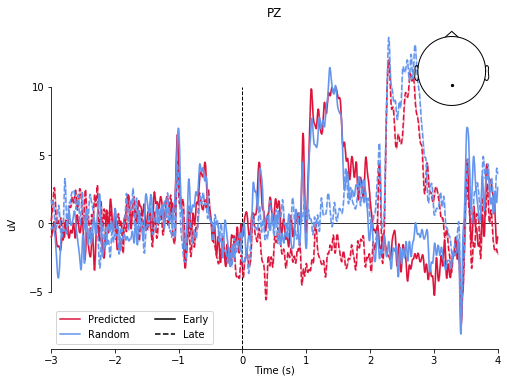

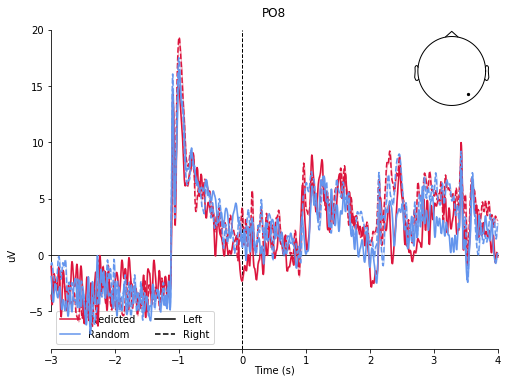

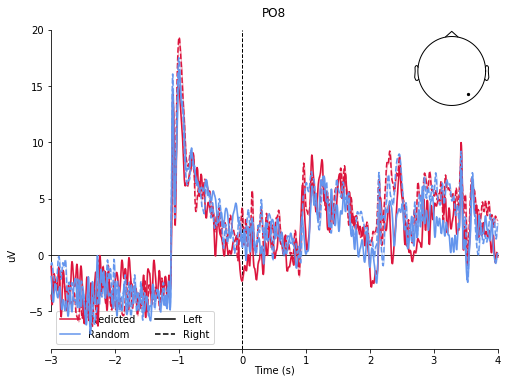

In [5]:
# Look at individual data
subNum = '29'
evoked_dummy = evokedO_dictAll['S' + str(subNum)]



#Plot specific conditions orienting
evoked_dict= dict()
evoked_dict['Predicted/Early'] = evokedO_dictAll['S' + str(subNum)]['Early/Predicted'] # Do right minus left?

evoked_dict['Predicted/Late'] = evokedO_dictAll['S' + str(subNum)]['Late/Predicted']

evoked_dict['Random/Early'] = evokedO_dictAll['S' + str(subNum)]['Early/Random']
evoked_dict['Random/Late'] = evokedO_dictAll['S' + str(subNum)]['Late/Random']



pick = evoked_dict["Predicted/Early"].ch_names.index('PZ')

linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)



# Plot Learning condition effect left vs right target first
evoked_dict= dict()
evoked_dict['Predicted/Left'] = evokedL_dictAll['S' + str(subNum)]['Predicted/Left'] # Do right minus left?

evoked_dict['Predicted/Right'] = evokedL_dictAll['S' + str(subNum)]['Predicted/Right']

evoked_dict['Random/Left'] = evokedL_dictAll['S' + str(subNum)]['Random/Left']
evoked_dict['Random/Right'] = evokedL_dictAll['S' + str(subNum)]['Random/Right']



pick = evoked_dict["Predicted/Left"].ch_names.index('PO8')

linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)



In [36]:
# Create dictionary of grandaverage objects per condition
GAVG_orienting = dict()
#subs = [11, 12, 14, 16, 17, 22, 23, 24,  29, 30]
subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30]
num = 0
for j in list(evokedO_dictAll['S18'].keys()):
    all_inst = []
    for i in subs:
        all_inst.append(evokedO_dictAll['S'+ str(i)][j])

    GAVG_orienting[j] =  mne.grand_average(all_inst, interpolate_bads=True, drop_bads=True)

    
GAVG_learning = dict()


num = 0
for j in list(evokedL_dictAll['S18'].keys()):
    all_inst = []
    for i in subs:
        all_inst.append(evokedL_dictAll['S'+ str(i)][j])

    GAVG_learning[j] =  mne.grand_average(all_inst, interpolate_bads=True, drop_bads=True)

Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:
['AF8']
Identifying common channels ...
Dropped the following channels:


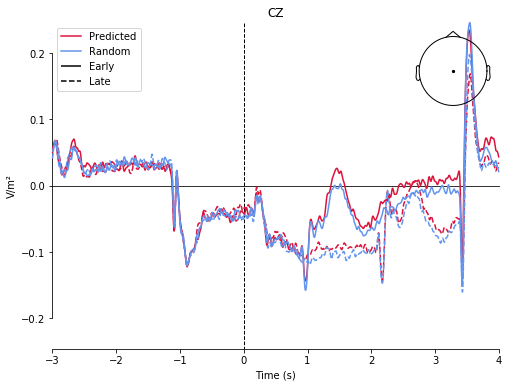

[<Figure size 576x432 with 2 Axes>]

In [38]:
#Plot specific conditions orienting
evoked_dict= dict()
evoked_dict['Predicted/Early'] = GAVG_orienting['Early/Predicted'] # Do right minus left?

evoked_dict['Predicted/Late'] = GAVG_orienting['Late/Predicted']

evoked_dict['Random/Early'] = GAVG_orienting['Early/Random']
evoked_dict['Random/Late'] = GAVG_orienting['Late/Random']



pick = evoked_dict["Predicted/Early"].ch_names.index('CZ')

linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

In [14]:
evokedO_dictAll['S18'].keys()

dict_keys(['Early/Random/Left', 'Early/Random/Right', 'Late/Random/Left', 'Late/Random/Right', 'Early/Predicted/Left', 'Early/Predicted/Right', 'Late/Predicted/Left', 'Late/Predicted/Right', 'Early/Random', 'Late/Random', 'Early/Predicted', 'Late/Predicted', 'Early/Random/RespLeft', 'Early/Random/RespRight', 'Late/Random/RespLeft', 'Late/Random/RespRight', 'Early/Predicted/RespLeft', 'Early/Predicted/RespRight', 'Late/Predicted/RespLeft', 'Late/Predicted/RespRight'])

In [79]:
# Run clustering algorithm

from mne.stats import permutation_cluster_test

channel = 'AFZ' 
#chanInd = evokedO_dictAll['S18']['Early/Predicted'].ch_names.index(channel)

cond1 = 'Late/Predicted'
cond2 = 'Late/Random'

tWin = [-1.2, 3.0]
timesOrig = evokedO_dictAll['S18'][cond1].times 
tInd = (timesOrig > tWin[0]) & (timesOrig< tWin[1])

subNum = 0

condition1 = np.zeros((len(subs),  sum(tInd)))
condition2 = np.zeros((len(subs),  sum(tInd)))

for i in subs:
    chanInd = evokedO_dictAll['S' + str(i)]['Early/Predicted'].ch_names.index(channel)
    
    condition1[subNum,:] = evokedO_dictAll['S' + str(i)][cond1].data[chanInd,tInd] # doesn't work for all elecs yet
    condition2[subNum,:] = evokedO_dictAll['S' + str(i)][cond2].data[chanInd,tInd]
    subNum += 1



#condition1 = condition1[:, chanInd, :]  # take only one channel to get a 2D array (subject x channels x time)
#condition2 = condition2[:, chanInd, :]  # take only one channel to get a 2D array

threshold = 1.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=0, n_jobs=1)

stat_fun(H1): min=0.000000 max=5.008345
Running initial clustering
Found 37 clusters
Permuting 999 times...
[........................................] 100.00%  |
Computing cluster p-values
Done.


<IPython.core.display.Javascript object>


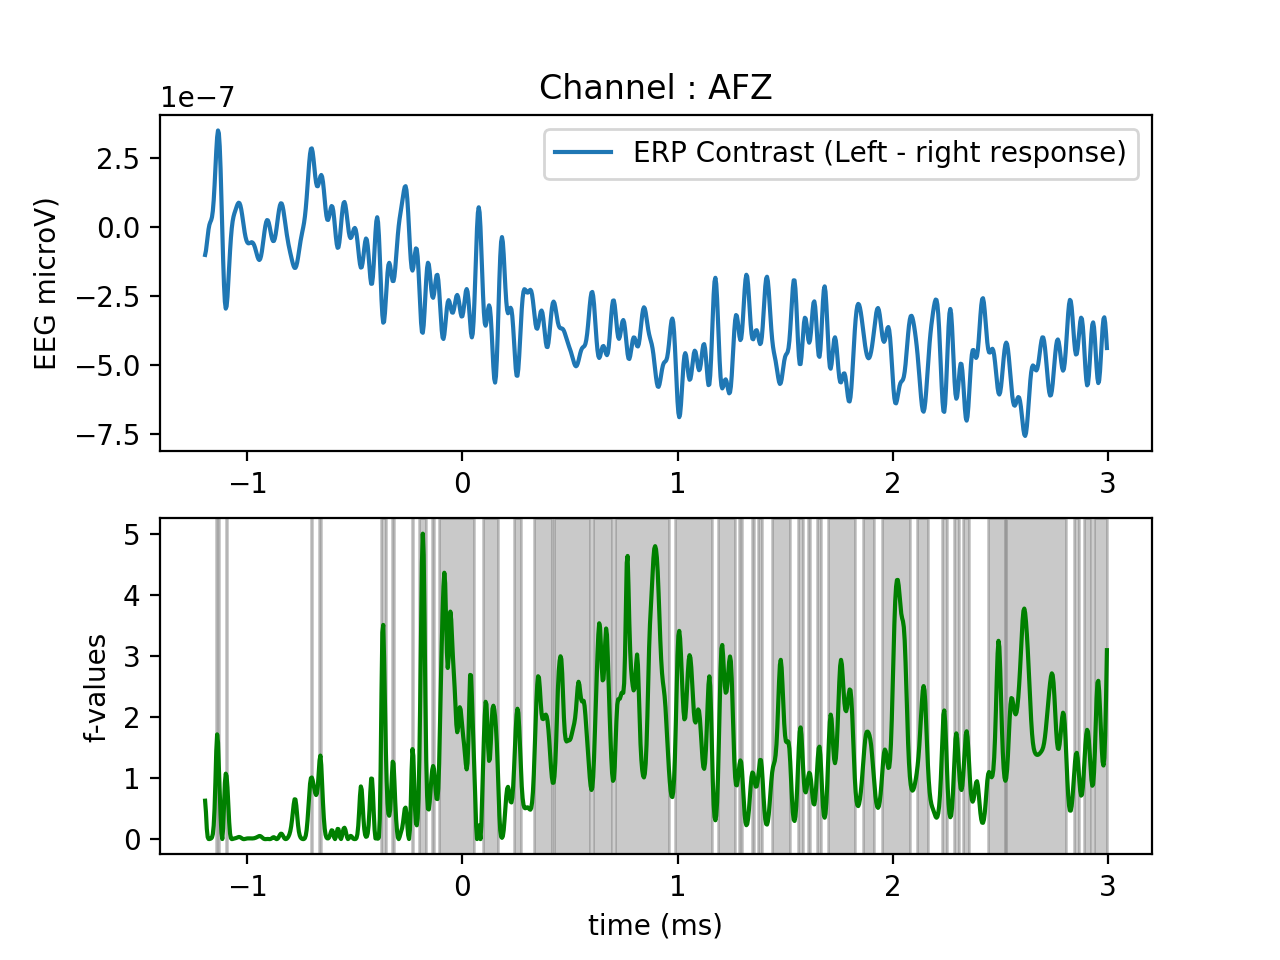

[1.    1.    1.    1.    0.994 1.    1.    0.968 1.    0.622 0.956 0.997
 0.912 0.692 0.819 0.44  0.637 0.878 1.    1.    1.    0.92  1.    1.
 1.    0.785 0.991 0.703 0.978 1.    1.    1.    0.943 0.488 1.    0.998
 0.962]


In [80]:
# Plot results
#times = GAVG_orienting['Early/Predicted'].times
times = timesOrig[tInd]
plt.close('all')
plt.subplot(211)
plt.title('Channel : ' + channel)
plt.plot(times, np.mean(condition1, axis = 0) - np.mean(condition2, axis = 0),
         label="ERP Contrast (Left - right response)")
plt.ylabel("EEG microV)")
plt.legend()
plt.subplot(212)
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        h = plt.axvspan(times[c.start], times[c.stop - 1],
                        color='r', alpha=0.3)
    else:
        plt.axvspan(times[c.start], times[c.stop - 1], color=(0.3, 0.3, 0.3),
                    alpha=0.3)
hf = plt.plot(times, T_obs, 'g')
#plt.legend((h, ), ('cluster p-value < 0.05', ))
plt.xlabel("time (ms)")
plt.ylabel("f-values")
plt.show()

print(cluster_p_values)

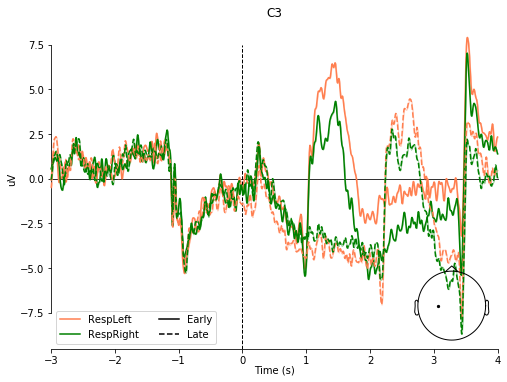

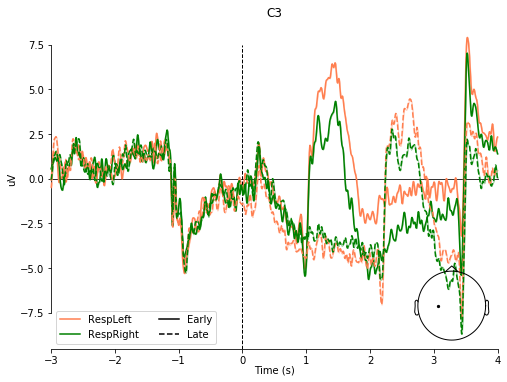

In [27]:
#Plot specific conditions orienting
evoked_dict= dict()
evoked_dict['Predicted/Early/RespLeft'] = GAVG_orienting['Early/Predicted/RespLeft'] # Do right minus left?

evoked_dict['Predicted/Early/RespRight'] = GAVG_orienting['Early/Predicted/RespRight']

evoked_dict['Predicted/Late/RespLeft'] = GAVG_orienting['Late/Predicted/RespLeft']
evoked_dict['Predicted/Late/RespRight'] = GAVG_orienting['Late/Predicted/RespRight']



pick = evoked_dict["Predicted/Early/RespLeft"].ch_names.index('C3')

linestyles = dict(Early = '-', Late = '--')
colors = dict(RespLeft = "Coral", RespRight = "Green")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

ValueError: Some of the values  to be plotted are NaN.

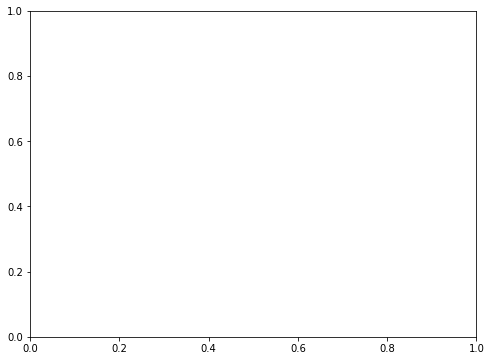

In [53]:
#Plot specific conditions orienting
evoked_dict= dict()
evoked_dict['Random/Early/Left'] = GAVG_orienting['Early/Random/Left'] # Do right minus left?

evoked_dict['Random/Early/Right'] = GAVG_orienting['Early/Random/Right']

evoked_dict['Random/Late/Left'] = GAVG_orienting['Late/Random/Left']
evoked_dict['Random/Late/Right'] = GAVG_orienting['Late/Random/Right']



pick = evoked_dict["Random/Early/Left"].ch_names.index('PO8')

linestyles = dict(Early = '-', Late = '--')
colors = dict(Left = "Crimson", Right = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

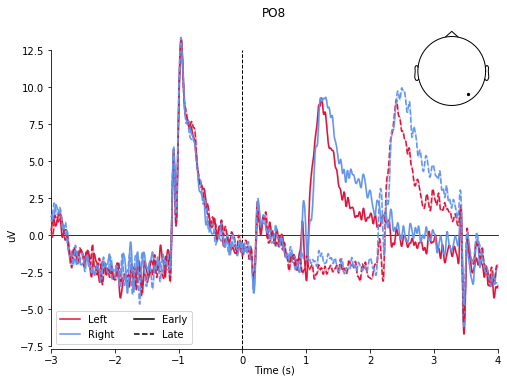

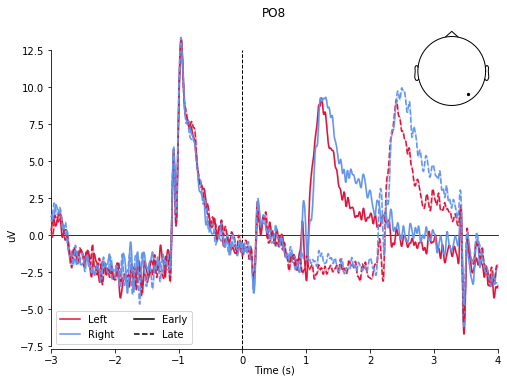

In [45]:
#Plot specific conditions orienting
evoked_dict= dict()
evoked_dict['Predicted/Early/Left'] = GAVG_orienting['Early/Predicted/Left'] # Do right minus left?

evoked_dict['Predicted/Early/Right'] = GAVG_orienting['Early/Predicted/Right']

evoked_dict['Predicted/Late/Left'] = GAVG_orienting['Late/Predicted/Left']
evoked_dict['Predicted/Late/Right'] = GAVG_orienting['Late/Predicted/Right']



pick = evoked_dict["Predicted/Early/Left"].ch_names.index('PO8')

linestyles = dict(Early = '-', Late = '--')
colors = dict(Left = "Crimson", Right = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

In [56]:
# Run clustering algorithm

from mne.stats import permutation_cluster_test

channel = 'PO8' 
#chanInd = evokedO_dictAll['S18']['Early/Predicted'].ch_names.index(channel)

cond1 = 'Late/Predicted/Left'
cond2 = 'Late/Predicted/Right'

tWin = [0., 3.0]
timesOrig = evokedO_dictAll['S18'][cond1].times 
tInd = (timesOrig > tWin[0]) & (timesOrig< tWin[1])

subNum = 0

condition1 = np.zeros((len(subs),  sum(tInd)))
condition2 = np.zeros((len(subs),  sum(tInd)))

for i in subs:
    chanInd = evokedO_dictAll['S' + str(i)]['Early/Predicted'].ch_names.index(channel)
    
    condition1[subNum,:] = evokedO_dictAll['S' + str(i)][cond1].data[chanInd,tInd] # doesn't work for all elecs yet
    condition2[subNum,:] = evokedO_dictAll['S' + str(i)][cond2].data[chanInd,tInd]
    subNum += 1



#condition1 = condition1[:, chanInd, :]  # take only one channel to get a 2D array (subject x channels x time)
#condition2 = condition2[:, chanInd, :]  # take only one channel to get a 2D array

threshold = 2.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=0, n_jobs=1)

stat_fun(H1): min=0.000000 max=11.850164
Running initial clustering
Found 7 clusters
Permuting 999 times...
[........................................] 100.00%  |   
Computing cluster p-values
Done.


In [37]:
# Run clustering algorithm

from mne.stats import permutation_cluster_test

channel = 'C3' 
#chanInd = evokedO_dictAll['S18']['Early/Predicted'].ch_names.index(channel)

cond1 = 'Late/Predicted/RespLeft'
cond2 = 'Late/Predicted/RespRight'

tWin = [0., 3.0]
timesOrig = evokedO_dictAll['S18'][cond1].times 
tInd = (timesOrig > tWin[0]) & (timesOrig< tWin[1])

subNum = 0

condition1 = np.zeros((len(subs),  sum(tInd)))
condition2 = np.zeros((len(subs),  sum(tInd)))

for i in subs:
    chanInd = evokedO_dictAll['S' + str(i)]['Early/Predicted'].ch_names.index(channel)
    
    condition1[subNum,:] = evokedO_dictAll['S' + str(i)][cond1].data[chanInd,tInd] # doesn't work for all elecs yet
    condition2[subNum,:] = evokedO_dictAll['S' + str(i)][cond2].data[chanInd,tInd]
    subNum += 1



#condition1 = condition1[:, chanInd, :]  # take only one channel to get a 2D array (subject x channels x time)
#condition2 = condition2[:, chanInd, :]  # take only one channel to get a 2D array

threshold = 2.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=0, n_jobs=1)

stat_fun(H1): min=0.000071 max=6.453721
Running initial clustering
Found 14 clusters
Permuting 999 times...
[........................................] 100.00%  |   
Computing cluster p-values
Done.


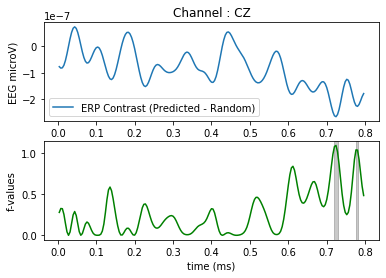

In [33]:
# Plot results
#times = GAVG_orienting['Early/Predicted'].times
times = timesOrig[tInd]
plt.close('all')
plt.subplot(211)
plt.title('Channel : ' + channel)
plt.plot(times, np.mean(condition1, axis = 0) - np.mean(condition2, axis = 0),
         label="ERP Contrast (Predicted - Random)")
plt.ylabel("EEG microV)")
plt.legend()
plt.subplot(212)
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        h = plt.axvspan(times[c.start], times[c.stop - 1],
                        color='r', alpha=0.3)
    else:
        plt.axvspan(times[c.start], times[c.stop - 1], color=(0.3, 0.3, 0.3),
                    alpha=0.3)
hf = plt.plot(times, T_obs, 'g')
#plt.legend((h, ), ('cluster p-value < 0.05', ))
plt.xlabel("time (ms)")
plt.ylabel("f-values")
plt.show()

In [32]:
# Run clustering algorithm Learning

from mne.stats import permutation_cluster_test

channel = 'CZ' 
#chanInd = evokedO_dictAll['S18']['Early/Predicted'].ch_names.index(channel)

cond1 = 'Predicted'
cond2 = 'Random'

tWin = [0., 0.8]
timesOrig = evokedL_dictAll['S18'][cond1].times 
tInd = (timesOrig > tWin[0]) & (timesOrig< tWin[1])

subNum = 0

condition1 = np.zeros((len(subs),  sum(tInd)))
condition2 = np.zeros((len(subs),  sum(tInd)))

for i in subs:
    chanInd = evokedL_dictAll['S' + str(i)]['Predicted/Left'].ch_names.index(channel)
    
    condition1[subNum,:] = evokedL_dictAll['S' + str(i)][cond1].data[chanInd,tInd] # doesn't work for all elecs yet
    condition2[subNum,:] = evokedL_dictAll['S' + str(i)][cond2].data[chanInd,tInd]
    subNum += 1



#condition1 = condition1[:, chanInd, :]  # take only one channel to get a 2D array (subject x channels x time)
#condition2 = condition2[:, chanInd, :]  # take only one channel to get a 2D array

threshold = 1.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=0, n_jobs=1)

stat_fun(H1): min=0.000009 max=1.093944
Running initial clustering
Found 2 clusters
Permuting 999 times...
[........................................] 100.00%  |
Computing cluster p-values
Done.


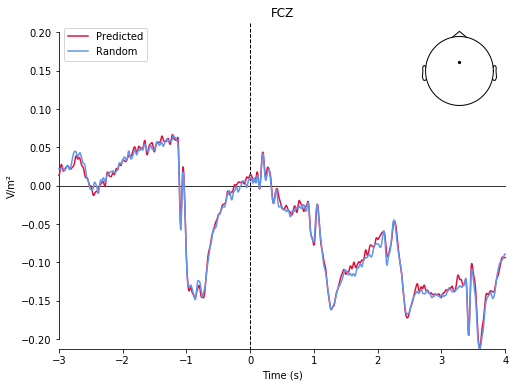

[<Figure size 576x432 with 2 Axes>]

In [40]:
# Plot Learning condition effect left vs right target first
evoked_dict= dict()
evoked_dict['Predicted'] = GAVG_learning['Predicted'] 

#evoked_dict['Predicted'] = GAVG_learning['Predicted']

evoked_dict['Random'] = GAVG_learning['Random']
#evoked_dict['Random'] = GAVG_learning['Random']



pick = evoked_dict["Predicted"].ch_names.index('FCZ')

#linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors, split_legend=True)

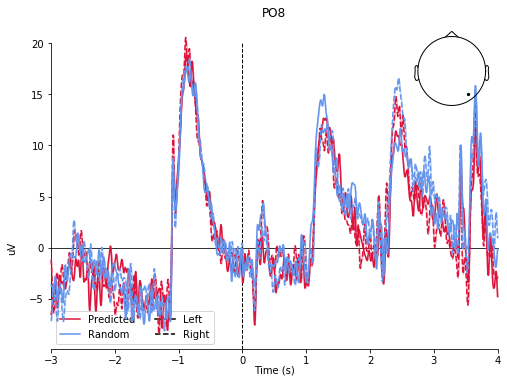

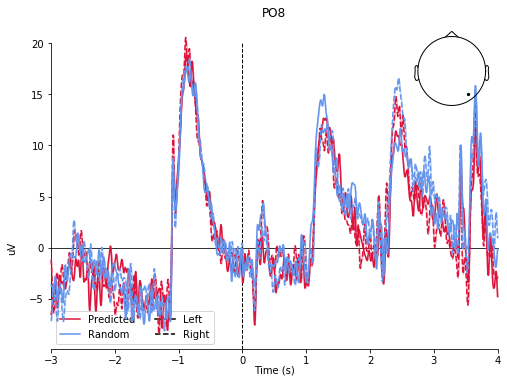

In [15]:
# Plot Learning condition effect left vs right target first
evoked_dict= dict()
evoked_dict['Predicted/Left'] = evokedL_dictAll['S' + str(subNum)]['Predicted/Left'] # Do right minus left?

evoked_dict['Predicted/Right'] = evokedL_dictAll['S' + str(subNum)]['Predicted/Right']

evoked_dict['Random/Left'] = evokedL_dictAll['S' + str(subNum)]['Random/Left']
evoked_dict['Random/Right'] = evokedL_dictAll['S' + str(subNum)]['Random/Right']



pick = evoked_dict["Predicted/Left"].ch_names.index('PO8')

linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

In [ ]:
GAVG_learning

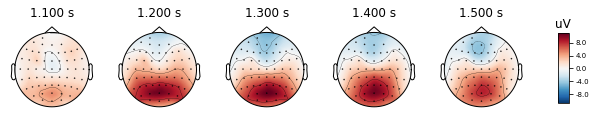

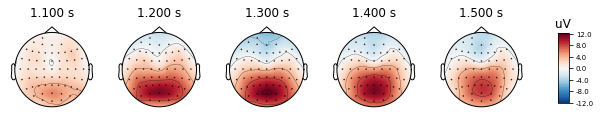

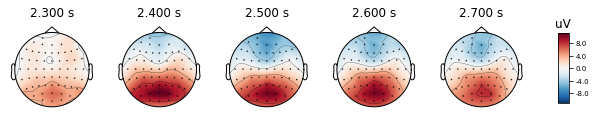

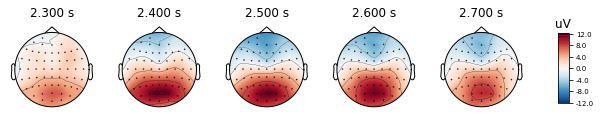

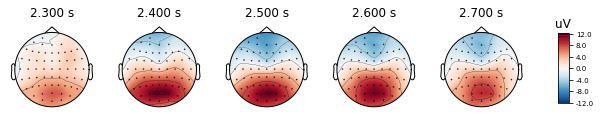

In [59]:
# Plot grandaverage

times = [1.1, 1.2, 1.3, 1.4, 1.5]
condition = 'Early/Random'
GAVG_orienting[condition].plot_topomap(times = times, ch_type = 'eeg', time_unit = 's')
condition = 'Early/Predicted'
GAVG_orienting[condition].plot_topomap(times = times, ch_type = 'eeg', time_unit = 's')

times = [2.3, 2.4, 2.5, 2.6, 2.7]
condition = 'Late/Random'
GAVG_orienting[condition].plot_topomap(times = times, ch_type = 'eeg', time_unit = 's')
condition = 'Late/Predicted'
GAVG_orienting[condition].plot_topomap(times = times, ch_type = 'eeg', time_unit = 's')

In [ ]:
# crop/trim

evoked_dict= dict()
evoked_dict['Predicted/Early'] = GAVG_orienting['Early/Predicted']

evoked_dict['Predicted/Late'] = GAVG_orienting['Late/Predicted']

evoked_dict['Random/Early'] = GAVG_orienting['Early/Random']
evoked_dict['Random/Late'] = GAVG_orienting['Late/Random']

pick = evoked_dict["Predicted/Early"].ch_names.index('PZ')

linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

xlim = (-0.2, 2.)

fig = mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

fig.set_figheight(8)
fig.set_figwidth(20)

In [77]:
mne.viz.plot_compare_evokeds?

In [ ]:
xlim = (1.5, 2.)
evoked_dict['Predicted/Early'].plot_image(xlim = xlim)
evoked_dict['Random/Early'].plot_image(xlim = xlim)
evoked_dict['Predicted/Late'].plot_image(xlim = xlim)
evoked_dict['Random/Late'].plot_image(xlim = xlim)

In [ ]:
evoked_dict['Predicted/Early'].plot_joint()
evoked_dict['Random/Early'].plot_joint()
evoked_dict['Random/Late'].plot_joint()

In [ ]:
mne.viz.plot_evoked_topo(evoked_dict['Predicted/Late'],background_color='w')

In [ ]:
mne.viz.plot_compare_evokeds?

In [ ]:
evoked_dict= dict()
evoked_dict['Predicted/Left'] = GAVG_learning['Predicted/Left']
evoked_dict['Predicted/Right'] = GAVG_learning['Predicted/Right']
evoked_dict['Random/Left'] = GAVG_learning['Random/Left']
evoked_dict['Random/Right'] = GAVG_learning['Random/Right']

pick = evoked_dict["Predicted/Left"].ch_names.index('PZ')
linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

In [ ]:
mne.viz.plot_compare_evokeds?

In [ ]:
%matplotlib notebook
evoked_dict= dict()
evoked_dict['nRep1'] = GAVG_learning['nRep1']
evoked_dict['nRep2'] = GAVG_learning['nRep2']
evoked_dict['nRep3'] = GAVG_learning['nRep3']
evoked_dict['nRep4'] = GAVG_learning['nRep4']
#evoked_dict['nRep5'] = GAVG_learning['nRep5']
#evoked_dict['nRep6'] = GAVG_learning['nRep6']

#pick = evoked_dict["nRep1"].ch_names.index('PZ')

pick = []
elec = ['PZ', 'POZ', 'P1', 'P2']
for k in elec: 
    pick.append(evoked_dict['nRep1'].ch_names.index(k))
#linestyles = dict(Left = '-', Right = '--')
#colors = dict(nRep1 = 'Gainsboro', nRep2 = 'LightGray', nRep3 = 'Silver', nRep4 = 'DarkGray', nRep5 = 'Gray', nRep6 = 'DimGray' )
cmap = plt.cm.get_cmap('gray')
#colors = dict(nRep1 = cmap(0.2), nRep2 = cmap(0.3), nRep3 = cmap(0.4), nRep4 = cmap(0.5), nRep5 = cmap(0.6), nRep6 = cmap(0.7) )
colors = dict(nRep1 = cmap(0.7), nRep2 = cmap(0.6), nRep3 = cmap(0.5), nRep4 = cmap(0.4))#, nRep5 = cmap(0.3), nRep6 = cmap(0.2) )



mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors = colors, split_legend=True, vlines = [-1.2, 0, 0.8, 2.0])

In [ ]:
evoked_dict= dict()
evoked_dict['Predicted/nRep1'] = GAVG_learning['Predicted/nRep1']
evoked_dict['Predicted/nRep2'] = GAVG_learning['Predicted/nRep2']
evoked_dict['Predicted/nRep3'] = GAVG_learning['Predicted/nRep3']
evoked_dict['Predicted/nRep4'] = GAVG_learning['Predicted/nRep4']
evoked_dict['Predicted/nRep5'] = GAVG_learning['Predicted/nRep5']
evoked_dict['Predicted/nRep6'] = GAVG_learning['Predicted/nRep6']

pick = evoked_dict["Predicted/nRep1"].ch_names.index('CPZ')
#linestyles = dict(Left = '-', Right = '--')
colors = dict(nRep1 = 'Gainsboro', nRep2 = 'LightGray', nRep3 = 'Silver', nRep4 = 'DarkGray', nRep5 = 'Gray', nRep6 = 'DimGray' )

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors = colors, split_legend=True)

In [ ]:
evoked_dict= dict()
evoked_dict['Random/nRep1'] = GAVG_learning['Random/nRep1']
evoked_dict['Random/nRep2'] = GAVG_learning['Random/nRep2']
evoked_dict['Random/nRep3'] = GAVG_learning['Random/nRep3']
evoked_dict['Random/nRep4'] = GAVG_learning['Random/nRep4']
evoked_dict['Random/nRep5'] = GAVG_learning['Random/nRep5']
evoked_dict['Random/nRep6'] = GAVG_learning['Random/nRep6']

pick = evoked_dict["Random/nRep1"].ch_names.index('POZ')

pick = []
elec = ['POZ']#'PZ', 'CPZ', 'POZ', 'P1']
for k in elec: 
    pick.append(evoked_dict['Random/nRep1'].ch_names.index(k))
#linestyles = dict(Left = '-', Right = '--')
colors = dict(nRep1 = 'Gainsboro', nRep2 = 'LightGray', nRep3 = 'Silver', nRep4 = 'DarkGray', nRep5 = 'Gray', nRep6 = 'DimGray' )
cmap = plt.cm.get_cmap('Greens')
#colors = dict(nRep1 = cmap(0.6), nRep2 = cmap(0.5), nRep3 = cmap(0.4), nRep4 = cmap(0.3), nRep5 = cmap(0.2), nRep6 = cmap(0.1) )


mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors = colors, split_legend=True)

In [ ]:
cmap(0.0)

/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


ValueError: Some of the values  to be plotted are NaN.

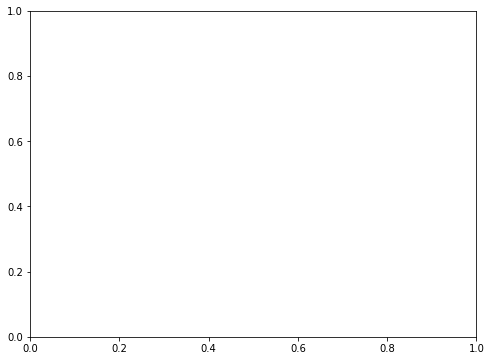

In [63]:
# N2PC - look at 200-300ms post stim, PO7/PO8

evoked_dict= dict()
evoked_dict['Predicted/Early/Left'] = GAVG_orienting['Early/Predicted/Left'] # Do right minus left?

evoked_dict['Predicted/Late/Left'] = GAVG_orienting['Late/Predicted/Left']

evoked_dict['Random/Early/Left'] = GAVG_orienting['Early/Random/Left']
evoked_dict['Random/Late/Left'] = GAVG_orienting['Late/Random/Left']



pick = evoked_dict["Predicted/Early/Left"].ch_names.index('PO8')

linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)



In [ ]:
# N2PC - look at 200-300ms post stim, PO7/PO8. Right target: do PO7-PO8 (contra - ipsi) Left: PO8-PO7

evoked_dict= dict()
evoked_dict['Predicted/Early/Right'] = GAVG_orienting['Early/Predicted/Right'] # Do right minus left?

evoked_dict['Predicted/Late/Right'] = GAVG_orienting['Late/Predicted/Right']

evoked_dict['Random/Early/Right'] = GAVG_orienting['Early/Random/Right']
evoked_dict['Random/Late/Right'] = GAVG_orienting['Late/Random/Right']



pick = evoked_dict["Predicted/Early/Right"].ch_names.index('PZ')

linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

xlim = (-0.2, 2.)

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)


In [ ]:
evokedO_dictAll

In [82]:
# Calculate difference waves for n2pc - collapse over early/late - keep early as a placeholder to make plotting easier

leftElec = 'PO7'
rightElec = 'PO8'
#LRdict = dict()
#LRdictAll = dict()

#subs = [1, 3, 4, 6,7,9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,26, 27, 29, 30]
subs = [18, 19, 20, 21, 22, 23, 24, 25,26, 27, 29, 30]

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[1]))

LRdict = {'PO8/Random/Early': emptyNp.copy(), 'PO7/Random/Early': emptyNp.copy(), 'PO7/Predicted/Early': emptyNp.copy(), 'PO8/Predicted/Early': emptyNp.copy(),
       'EarlyDiff': emptyNp.copy(), 'LateDiff': emptyNp.copy(), 
         'PO7/EarlyDiff': emptyNp.copy(),  'PO8/EarlyDiff': emptyNp.copy(), }
num = 0
for i in subs:
    
    
    leftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(leftElec)
    rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    LRdict['PO8/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Random/Left'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Random/Right'].data[rightInd,:]
    LRdict['PO7/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Random/Right'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Random/Left'].data[leftInd,:]

    LRdict['PO7/Predicted/Early'][num,:]= evokedO_dictAll['S' + str(i)]['Predicted/Right'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Predicted/Left'].data[leftInd,:]
    LRdict['PO8/Predicted/Early'][num,:]= evokedO_dictAll['S' + str(i)]['Predicted/Left'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Predicted/Right'].data[rightInd,:]

    #LRdict['PO8/Random/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[rightInd,:]
    #LRdict['PO7/Random/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[leftInd,:]

    #LRdict['PO7/Predicted/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[leftInd,:]
    #LRdict['PO8/Predicted/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[rightInd,:]

    LRdict['PO7/EarlyDiff'][num,:] = (LRdict['PO7/Predicted/Early'][num,:] - LRdict['PO7/Random/Early'][num,:])
    #LRdict['PO7/LateDiff'][num,:] = (LRdict['PO7/Predicted/Late'][num,:] - LRdict['PO7/Random/Late'][num,:])
    LRdict['PO8/EarlyDiff'][num,:] = (LRdict['PO8/Predicted/Early'][num,:] - LRdict['PO8/Random/Early'][num,:])
    #LRdict['PO8/LateDiff'][num,:] = (LRdict['PO8/Predicted/Late'][num,:] - LRdict['PO8/Random/Late'][num,:])
    
    LRdict['EarlyDiff'][num,:] = (LRdict['PO7/EarlyDiff'][num,:] + LRdict['PO8/EarlyDiff'][num,:])/2
    #LRdict['LateDiff'][num,:] = (LRdict['PO7/LateDiff'][num,:] + LRdict['PO8/LateDiff'][num,:])/2
    #LRdictAll['S' + str(i)] = LRdict
    num += 1

  

In [21]:
# Calculate difference waves for n2pc

leftElec = 'PO7'
rightElec = 'PO8'
#LRdict = dict()
#LRdictAll = dict()

#subs = [1, 3, 4, 6,7,9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,26, 27, 29, 30]
subs = [18, 19, 20, 21, 22, 23, 24, 25,26, 27, 29, 30]

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[1]))

LRdict = {'PO8/Random/Early': emptyNp.copy(), 'PO7/Random/Early': emptyNp.copy(), 'PO7/Predicted/Early': emptyNp.copy(), 'PO8/Predicted/Early': emptyNp.copy(),
      'PO8/Random/Late': emptyNp.copy(), 'PO7/Random/Late': emptyNp.copy(),  'PO7/Predicted/Late': emptyNp.copy(), 'PO8/Predicted/Late': emptyNp.copy(), 'EarlyDiff': emptyNp.copy(), 'LateDiff': emptyNp.copy(), 
         'PO7/EarlyDiff': emptyNp.copy(), 'PO7/LateDiff': emptyNp.copy(), 'PO8/EarlyDiff': emptyNp.copy(), 'PO8/LateDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    
    leftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(leftElec)
    rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    LRdict['PO8/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[rightInd,:]
    LRdict['PO7/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[leftInd,:]

    LRdict['PO7/Predicted/Early'][num,:]= evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[leftInd,:]
    LRdict['PO8/Predicted/Early'][num,:]= evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[rightInd,:]

    LRdict['PO8/Random/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[rightInd,:]
    LRdict['PO7/Random/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[leftInd,:]

    LRdict['PO7/Predicted/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[leftInd,:]
    LRdict['PO8/Predicted/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[rightInd,:]

    LRdict['PO7/EarlyDiff'][num,:] = (LRdict['PO7/Predicted/Early'][num,:] - LRdict['PO7/Random/Early'][num,:])
    LRdict['PO7/LateDiff'][num,:] = (LRdict['PO7/Predicted/Late'][num,:] - LRdict['PO7/Random/Late'][num,:])
    LRdict['PO8/EarlyDiff'][num,:] = (LRdict['PO8/Predicted/Early'][num,:] - LRdict['PO8/Random/Early'][num,:])
    LRdict['PO8/LateDiff'][num,:] = (LRdict['PO8/Predicted/Late'][num,:] - LRdict['PO8/Random/Late'][num,:])
    
    LRdict['EarlyDiff'][num,:] = (LRdict['PO7/EarlyDiff'][num,:] + LRdict['PO8/EarlyDiff'][num,:])/2
    LRdict['LateDiff'][num,:] = (LRdict['PO7/LateDiff'][num,:] + LRdict['PO8/LateDiff'][num,:])/2
    #LRdictAll['S' + str(i)] = LRdict
    num += 1

  
    

In [41]:
# left vs right responses 


leftElec = 'C3'
rightElec = 'C4'
#LRdict = dict()
#LRdictAll = dict()

subs = [1, 3, 4, 6,7,9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,26, 27, 29, 30]

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[1]))

LRrespdict = {'C4/Random/Early': emptyNp.copy(), 'C3/Random/Early': emptyNp.copy(), 'C3/Predicted/Early': emptyNp.copy(), 'C4/Predicted/Early': emptyNp.copy(),
      'C4/Random/Late': emptyNp.copy(), 'C3/Random/Late': emptyNp.copy(),  'C3/Predicted/Late': emptyNp.copy(), 'C4/Predicted/Late': emptyNp.copy(),'EarlyDiff': emptyNp.copy(), 'LateDiff': emptyNp.copy(), 
         'C3/EarlyDiff': emptyNp.copy(), 'C3/LateDiff': emptyNp.copy(), 'C4/EarlyDiff': emptyNp.copy(), 'C4/LateDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    
    leftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(leftElec)
    rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    LRrespdict['C4/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[rightInd,:]
    LRrespdict['C3/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[leftInd,:]

    LRrespdict['C4/Predicted/Early'][num,:]= evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[rightInd,:]
    LRrespdict['C3/Predicted/Early'][num,:]= evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[leftInd,:]

    LRrespdict['C3/Random/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[leftInd,:]
    LRrespdict['C4/Random/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[rightInd,:]

    LRrespdict['C3/Predicted/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[leftInd,:]
    LRrespdict['C4/Predicted/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[rightInd,:]

    LRrespdict['C3/EarlyDiff'][num,:] = (LRrespdict['C3/Predicted/Early'][num,:] - LRrespdict['C3/Random/Early'][num,:])
    LRrespdict['C3/LateDiff'][num,:] = (LRrespdict['C3/Predicted/Late'][num,:] - LRrespdict['C3/Random/Late'][num,:])
    LRrespdict['C4/EarlyDiff'][num,:] = (LRrespdict['C4/Predicted/Early'][num,:] - LRrespdict['C4/Random/Early'][num,:])
    LRrespdict['C4/LateDiff'][num,:] = (LRrespdict['C4/Predicted/Late'][num,:] - LRrespdict['C4/Random/Late'][num,:])
    
    LRrespdict['EarlyDiff'][num,:] = (LRrespdict['C3/EarlyDiff'][num,:] + LRrespdict['C4/EarlyDiff'][num,:])/2
    LRrespdict['LateDiff'][num,:] = (LRrespdict['C3/LateDiff'][num,:] + LRrespdict['C4/LateDiff'][num,:])/2
    #LRdictAll['S' + str(i)] = LRdict
    num += 1



In [49]:
# left vs right responses  -- expected correct response!


leftElec = 'C3'
rightElec = 'C4'
#LRdict = dict()
#LRdictAll = dict()

#subs = [1, 3, 4, 6,7,9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,26, 27, 29, 30]
subs = [11, 12, 14, 16, 17, 22, 23, 24,  29, 30]
emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[1]))

LRrespdict = {'C4/Random/Early': emptyNp.copy(), 'C3/Random/Early': emptyNp.copy(), 'C3/Predicted/Early': emptyNp.copy(), 'C4/Predicted/Early': emptyNp.copy(),
      'C4/Random/Late': emptyNp.copy(), 'C3/Random/Late': emptyNp.copy(),  'C3/Predicted/Late': emptyNp.copy(), 'C4/Predicted/Late': emptyNp.copy(),'EarlyDiff': emptyNp.copy(), 'LateDiff': emptyNp.copy(), 
         'C3/EarlyDiff': emptyNp.copy(), 'C3/LateDiff': emptyNp.copy(), 'C4/EarlyDiff': emptyNp.copy(), 'C4/LateDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    
    leftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(leftElec)
    rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    LRrespdict['C4/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeftC'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Early/Random/RespRightC'].data[rightInd,:]
    LRrespdict['C3/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Early/Random/RespRightC'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Early/Random/RespLeftC'].data[leftInd,:]

    LRrespdict['C4/Predicted/Early'][num,:]= evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeftC'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRightC'].data[rightInd,:]
    LRrespdict['C3/Predicted/Early'][num,:]= evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRightC'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeftC'].data[leftInd,:]

    LRrespdict['C3/Random/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Random/RespRightC'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/RespLeftC'].data[leftInd,:]
    LRrespdict['C4/Random/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Random/RespLeftC'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/RespRightC'].data[rightInd,:]

    LRrespdict['C3/Predicted/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRightC'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeftC'].data[leftInd,:]
    LRrespdict['C4/Predicted/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeftC'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRightC'].data[rightInd,:]

    LRrespdict['C3/EarlyDiff'][num,:] = (LRrespdict['C3/Predicted/Early'][num,:] - LRrespdict['C3/Random/Early'][num,:])
    LRrespdict['C3/LateDiff'][num,:] = (LRrespdict['C3/Predicted/Late'][num,:] - LRrespdict['C3/Random/Late'][num,:])
    LRrespdict['C4/EarlyDiff'][num,:] = (LRrespdict['C4/Predicted/Early'][num,:] - LRrespdict['C4/Random/Early'][num,:])
    LRrespdict['C4/LateDiff'][num,:] = (LRrespdict['C4/Predicted/Late'][num,:] - LRrespdict['C4/Random/Late'][num,:])
    
    LRrespdict['EarlyDiff'][num,:] = (LRrespdict['C3/EarlyDiff'][num,:] + LRrespdict['C4/EarlyDiff'][num,:])/2
    LRrespdict['LateDiff'][num,:] = (LRrespdict['C3/LateDiff'][num,:] + LRrespdict['C4/LateDiff'][num,:])/2
    #LRdictAll['S' + str(i)] = LRdict
    num += 1



<IPython.core.display.Javascript object>


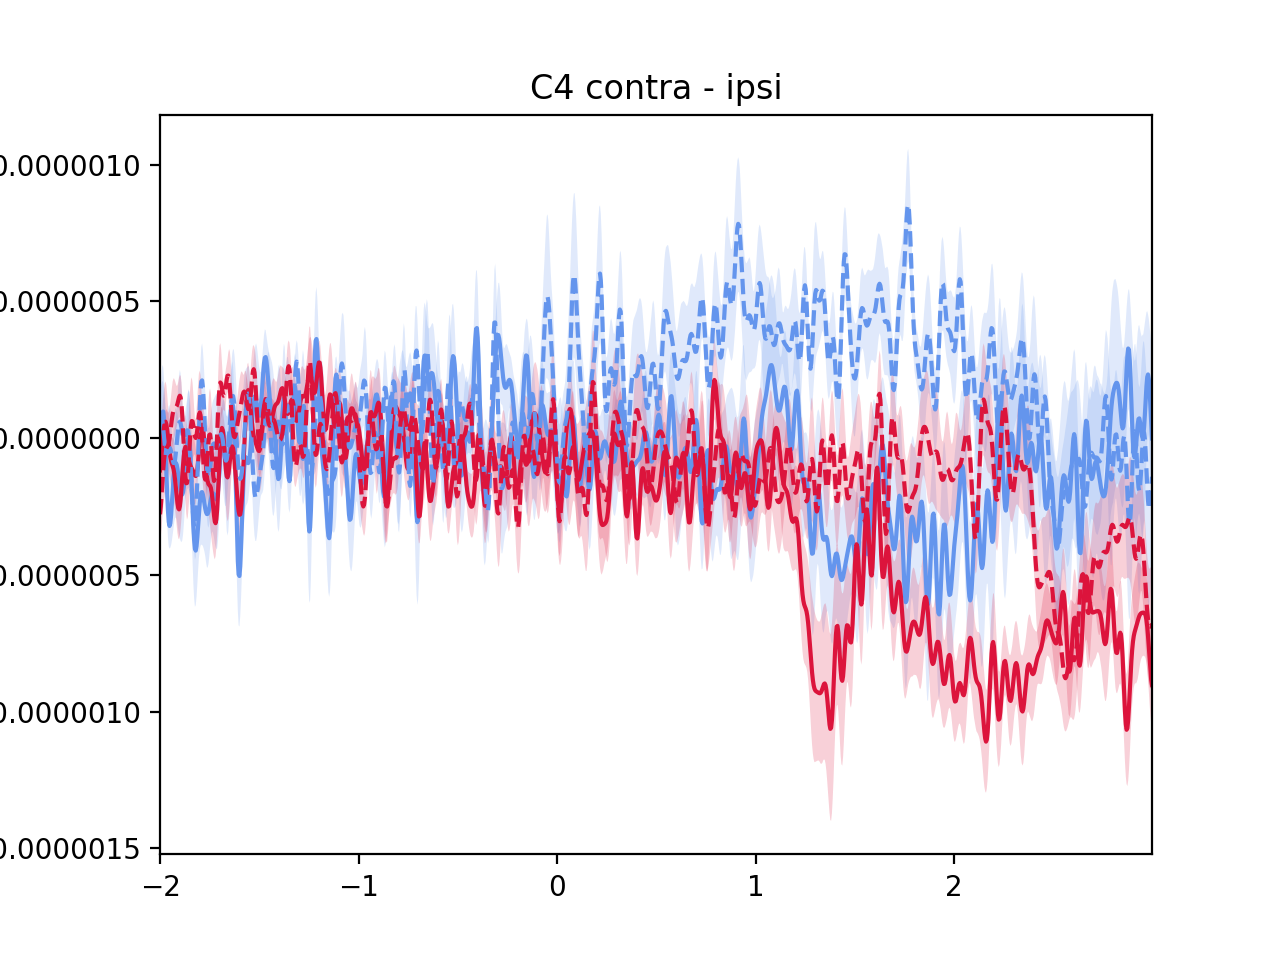

(1751,)
(10, 1751)
(1751,)
(10, 1751)
(1751,)
(10, 1751)
(1751,)
(10, 1751)


<IPython.core.display.Javascript object>


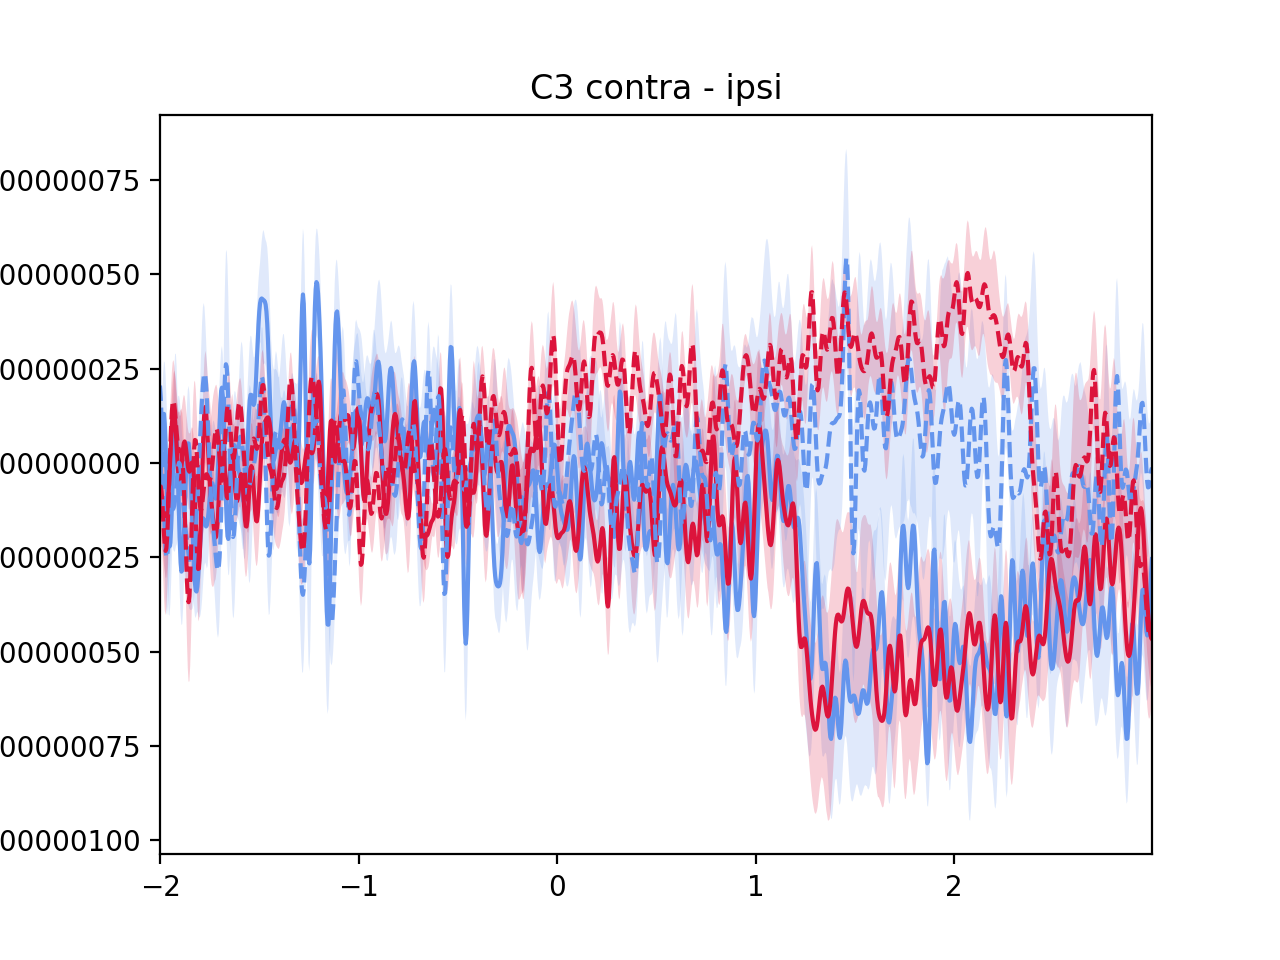

(1751,)
(10, 1751)
(1751,)
(10, 1751)
(1751,)
(10, 1751)
(1751,)
(10, 1751)


In [50]:
import seaborn as sb

%matplotlib notebook 

time = np.squeeze(np.arange(-3. - 1./250., 4., 1./250.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [-2, 3.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('C4 contra - ipsi')
# Plot PO8
for i in list(LRrespdict.keys())[:8]:
    if 'C4' in i:
        print(time.shape)
        print(LRrespdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRrespdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1)# , colors = colors, linestyles = linestyles)
        

        
fig2, ax2 = plt.subplots()

ax2.set_title('C3 contra - ipsi')

 # Plot PO7
for i in list(LRrespdict.keys())[:8]:
    if 'C3' in i:
        print(time.shape)
        print(LRrespdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRrespdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax2)#

<IPython.core.display.Javascript object>


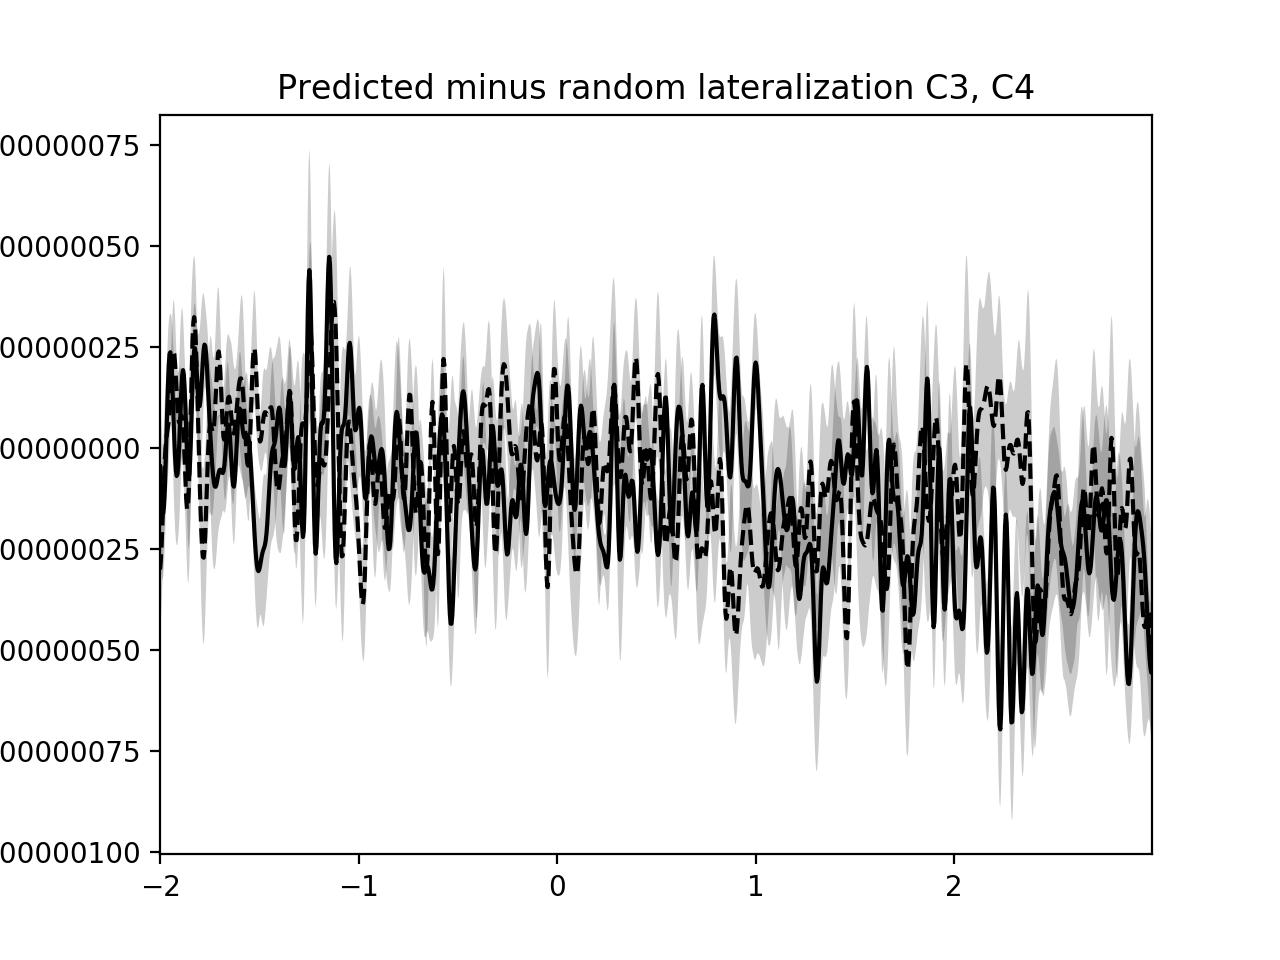

In [51]:
fig2, ax3 = plt.subplots()

ax3.set_title('Predicted minus random lateralization C3, C4')
for i in list(LRdict.keys())[8:10]:
    if 'C3' in i:
        color = 'coral'
    elif 'C4' in i: 
        color = 'green'
    else:
        color = 'black'
        
    if 'Early' in i:
            linestyle = '-'
    elif 'Late' in i:
            linestyle = '--'
        
    sb.tsplot(time = time[timeInd], data = LRrespdict[i][:,timeInd], color = color, linestyle = linestyle,  ax = ax3)#
        
    

In [84]:
list(LRdict.keys())

['PO8/Random/Early',
 'PO7/Random/Early',
 'PO7/Predicted/Early',
 'PO8/Predicted/Early',
 'EarlyDiff',
 'LateDiff',
 'PO7/EarlyDiff',
 'PO8/EarlyDiff']

<IPython.core.display.Javascript object>


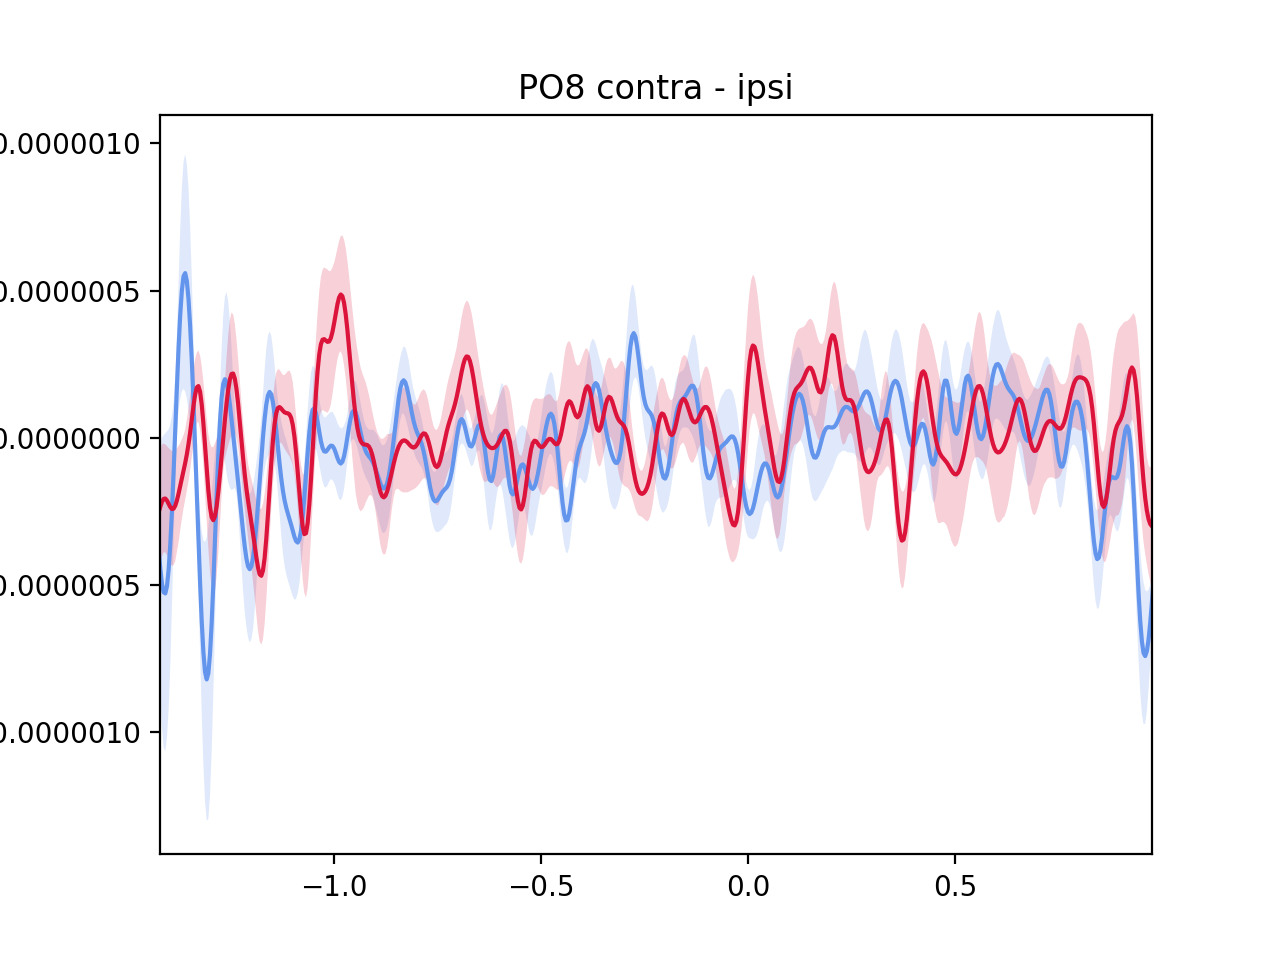

(1751,)
(12, 1751)
(1751,)
(12, 1751)


<IPython.core.display.Javascript object>


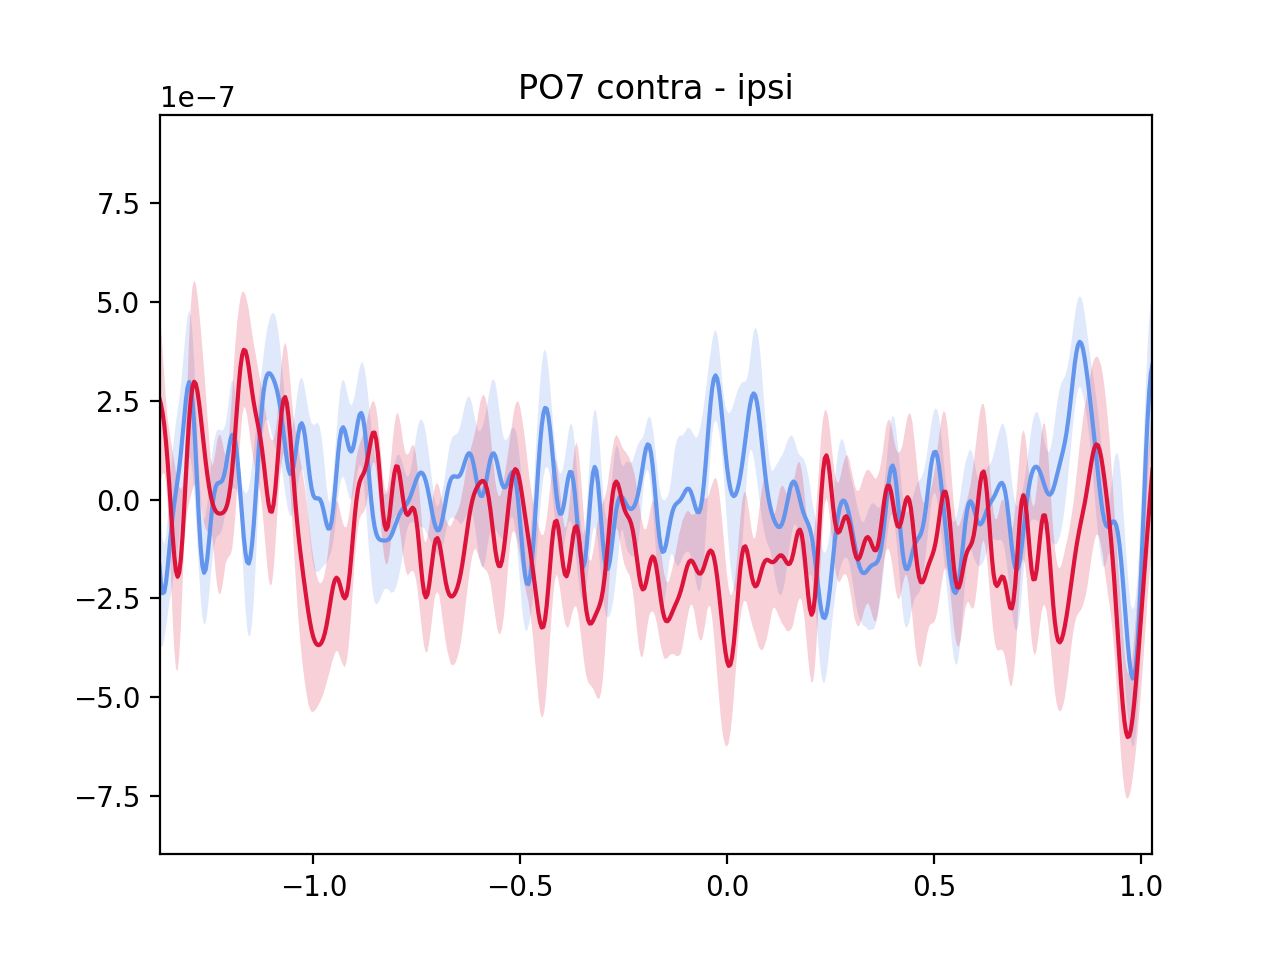

(1751,)
(12, 1751)
(1751,)
(12, 1751)


In [85]:
import seaborn as sb

%matplotlib notebook 

time = np.squeeze(np.arange(-3. - 1./250., 4., 1./250.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [-2., 3.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('PO8 contra - ipsi')
# Plot PO8
for i in list(LRdict.keys())[:4]:
    if 'PO8' in i:
        print(time.shape)
        print(LRdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1)# , colors = colors, linestyles = linestyles)
        

        
fig2, ax2 = plt.subplots()

ax2.set_title('PO7 contra - ipsi')

 # Plot PO7
for i in list(LRdict.keys())[:4]:
    if 'PO7' in i:
        print(time.shape)
        print(LRdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax2)#
        


<IPython.core.display.Javascript object>


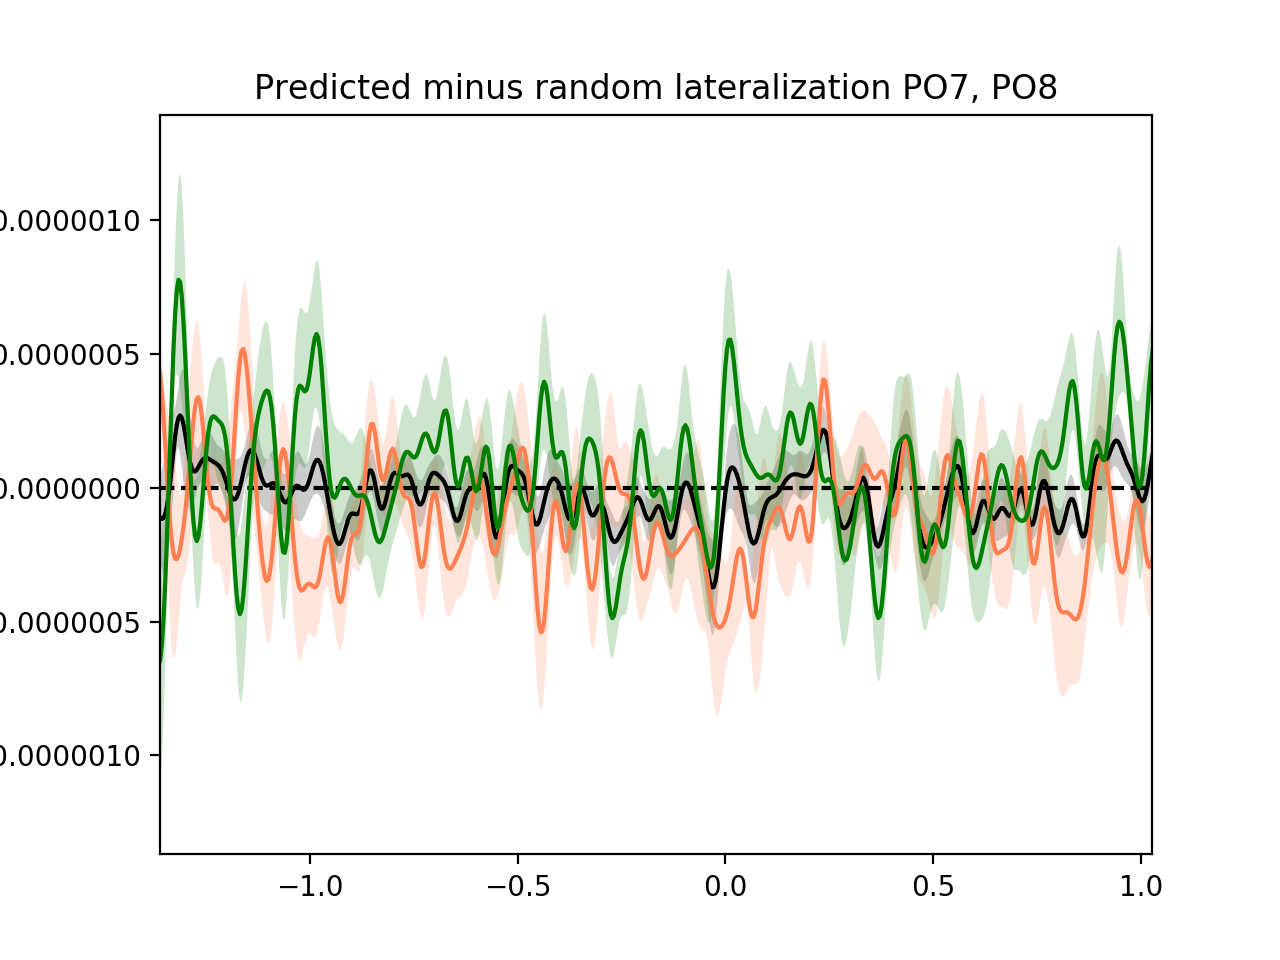

In [86]:
fig2, ax3 = plt.subplots()

ax3.set_title('Predicted minus random lateralization PO7, PO8')
for i in list(LRdict.keys())[4:]:
    if 'PO7' in i:
        color = 'coral'
    elif 'PO8' in i: 
        color = 'green'
    else:
        color = 'black'
        
    if 'Early' in i:
            linestyle = '-'
    elif 'Late' in i:
            linestyle = '--'
        
    sb.tsplot(time = time[timeInd], data = LRdict[i][:,timeInd], color = color, linestyle = linestyle,  ax = ax3)#
        
    

In [ ]:
# Plot PO7
for i in list(LRdict.keys()):
    if 'PO7' in i:
        print(time.shape)
        print(LRdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRdict[i][:,timeInd], color = color, linestyle = linestyle)#

In [ ]:
evokedO_dictAll['S18']['Early/Random/Left'].data.shape

In [ ]:
sb.tsplot?

In [ ]:
LRdict[i][0,:]

In [ ]:
evoked_dict= dict()
evoked_dict['Predicted/Early'] = GAVG_orienting['Early/Predicted']

evoked_dict['Predicted/Late'] = GAVG_orienting['Late/Predicted']

evoked_dict['Random/Early'] = GAVG_orienting['Early/Random']
evoked_dict['Random/Late'] = GAVG_orienting['Late/Random']

pick = evoked_dict["Predicted/Early"].ch_names.index('PZ')

linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

In [ ]:
#evokedL_dictAll

P300amp = dict()
P300lat = dict()
elec = 'PZ'
srate = 250

latencies = [0.2, 0.5]
for i in subs:
    

    tmp = dict()
    tmp2 = dict()
    for j in list(evokedL_dictAll['S18'].keys()):
        
        elecInd = evokedL_dictAll['S' + str(i)][j].ch_names.index(elec)
        timeInd = (evokedL_dictAll['S' + str(i)][j].times > latencies[0])*(evokedL_dictAll['S' + str(i)][j].times < latencies[1])
        tmp[j] = np.max(evokedL_dictAll['S'+ str(i)][j].data[elecInd, timeInd])
        tmp2[j] = latencies[0] + np.argmax(evokedL_dictAll['S'+ str(i)][j].data[elecInd, timeInd])/srate
    
    P300amp['S' + str(i)] = tmp
    P300lat['S' + str(i)] = tmp2

In [ ]:
ev_dict = dict()
tmp_dict = dict()




In [ ]:
# average across several electrodes

P300amp = dict()
P300lat = dict()
elec = ['PZ', 'POZ', 'P1', 'P2', 'CPZ']
srate = 250

latencies = [1.0, 1.4] # targets at 0.8s and 2s
latencies2 = [2.2, 2.8]

nRep = []
condition = []
subject = []

amp = []
lats = []
amp2 = []
lats2 = []

for i in subs:
    

    tmp = dict()
    tmp2 = dict()
    for j in list(evokedL_dictAll['S18'].keys()):
        if 'nRep' in j:
            
            if 'Random' in j or 'Predicted' in j:
            
                subject.append('S' + str(i))

                if 'Random' in j:
                    condition.append('Random')
                elif 'Predicted' in j:
                    condition.append('Predicted')

                if '1' in j:
                    nRep.append(1.0)
                elif '2' in j:
                    nRep.append(2.0)
                elif '3' in j: 
                    nRep.append(3.0)
                elif '4' in j:
                    nRep.append(4.0)
                elif '5' in j: 
                    nRep.append(5.0)
                elif '6' in j:
                    nRep.append(6.0)

                elecIndTmp = []
                for k in elec: 
                    elecIndTmp.append(evokedL_dictAll['S' + str(i)][j].ch_names.index(k))

                timeInd = (evokedL_dictAll['S' + str(i)][j].times > latencies[0])*(evokedL_dictAll['S' + str(i)][j].times < latencies[1])

                dataLen = evokedL_dictAll['S'+ str(i)][j].data.shape[0]
                elecInd = np.zeros((dataLen,1))
                elecInd[elecIndTmp] = True
                elecInd = np.squeeze(elecInd.astype(bool))

                data1 = []
                data1_2 = []
                data2_2 = []

                data1 = evokedL_dictAll['S'+ str(i)][j].data[elecInd, :]
                data1_2 = data1[:,timeInd]

                amp.append( np.max(np.mean(data1_2, axis = 0)))
                lats.append(latencies[0] + np.argmax(np.mean(data1_2, axis = 0))/srate)

                timeInd2 = (evokedL_dictAll['S' + str(i)][j].times > latencies2[0])*(evokedL_dictAll['S' + str(i)][j].times < latencies2[1])


                data2_2 = data1[:,timeInd2]

                amp2.append( np.max(np.mean(data2_2, axis = 0)))
                lats2.append(latencies2[0] + np.argmax(np.mean(data2_2, axis= 0))/srate)
            
            
    
d = {'Subject': subject, 'Condition': condition, 'nRep': nRep, 'PeakLatency1': lats, 'PeakAmplitude1': amp, 'PeakLatency2': lats2, 'PeakAmplitude2': amp2}
df = pd.DataFrame(d)

In [ ]:
evokedL_dictAll['S' + str(i)][j].data[elecInd,timeInd]

In [ ]:
sum(timeInd)

In [ ]:
# single electrode only
P300amp = dict()
P300lat = dict()
elec = 'PZ'
srate = 250

latencies = [1.0, 1.4] # targets at 0.8s and 2s
latencies2 = [2.2, 2.8]

nRep = []
condition = []
subject = []

amp = []
lats = []
amp2 = []
lats2 = []

for i in subs:
    

    tmp = dict()
    tmp2 = dict()
    for j in list(evokedL_dictAll['S18'].keys()):
        if 'nRep' in j:
            
            subject.append('S' + str(i))
            
            if 'Random' in j:
                condition.append('Random')
            elif 'Predicted' in j:
                condition.append('Predicted')
            
            if '1' in j:
                nRep.append(1.0)
            elif '2' in j:
                nRep.append(2.0)
            elif '3' in j: 
                nRep.append(3.0)
            elif '4' in j:
                nRep.append(4.0)
            elif '5' in j: 
                nRep.append(5.0)
            elif '6' in j:
                nRep.append(6.0)
            
            elecInd = evokedL_dictAll['S' + str(i)][j].ch_names.index(elec)
            timeInd = (evokedL_dictAll['S' + str(i)][j].times > latencies[0])*(evokedL_dictAll['S' + str(i)][j].times < latencies[1])
        
            amp.append( np.max(evokedL_dictAll['S'+ str(i)][j].data[elecInd, timeInd]))
            lats.append(latencies[0] + np.argmax(evokedL_dictAll['S'+ str(i)][j].data[elecInd, timeInd])/srate)
            
            timeInd2 = (evokedL_dictAll['S' + str(i)][j].times > latencies2[0])*(evokedL_dictAll['S' + str(i)][j].times < latencies2[1])
        
            amp2.append( np.max(evokedL_dictAll['S'+ str(i)][j].data[elecInd, timeInd2]))
            lats2.append(latencies2[0] + np.argmax(evokedL_dictAll['S'+ str(i)][j].data[elecInd, timeInd2])/srate)
            
            
    
d = {'Subject': subject, 'Condition': condition, 'nRep': nRep, 'PeakLatency1': lats, 'PeakAmplitude1': amp, 'PeakLatency2': lats2, 'PeakAmplitude2': amp2}
df = pd.DataFrame(d)

In [ ]:
print(len(subject))
print(len(condition))
print(len(nRep))



In [ ]:
df

In [ ]:
import seaborn as sb
sb.catplot(x = 'nRep', y = 'PeakAmplitude1', data = df, hue='Condition', kind = 'point')

sb.catplot(x = 'nRep', y = 'PeakAmplitude2', data = df, hue = 'Condition', kind = 'point' )


sb.catplot(x = 'nRep', y = 'PeakLatency1', data = df, hue = 'Condition', kind = 'point' )

sb.catplot(x = 'nRep', y = 'PeakLatency2', data = df, hue = 'Condition', kind = 'point' )

In [ ]:
sb.catplot?

In [ ]:
import seaborn as sb
import 

In [ ]:
import statsmodels.formula.api as smf

#dfLME = dfO.dropna(subset = ['pixelError']) # do 'RTselec1' 'MoveOnset' or 'pixelError'
dfLME = df.copy()
#dfLME['Scene'] = dfLME['Scene'].astype(str)
#dfLME['Delay'] = dfLME['Delay'].astype(str)
#dfLME= dfLME[dfLME['MoveOnset']> 100]


modelLMERT = smf.mixedlm("PeakAmplitude1 ~Condition + nRep + nRep*Condition",dfLME, groups = dfLME['Subject'])
LMERTFit = modelLMERT.fit()
print(LMERTFit.summary())

In [ ]:
# single electrode only
P300amp = dict()
P300lat = dict()
elec = 'PZ'
srate = 250

latencies = [1.0, 1.4] # targets at 0.8s and 2s
latencies2 = [2.2, 2.8]

nRep = []
condition = []
subject = []
delay = []

amp = []
lats = []
amp2 = []
lats2 = []

for i in subs:
    

    tmp = dict()
    tmp2 = dict()
    for j in list(['Early/Random', 'Early/Predicted', 'Late/Random', 'Late/Predicted']):
        if 'Early' in j:
            delay.append('Early')
            subject.append('S' + str(i))
            
            if 'Random' in j:
                condition.append('Random')
            elif 'Predicted' in j:
                condition.append('Predicted')
            
            
            
            elecInd = evokedO_dictAll['S' + str(i)][j].ch_names.index(elec)
            timeInd = (evokedO_dictAll['S' + str(i)][j].times > latencies[0])*(evokedO_dictAll['S' + str(i)][j].times < latencies[1])
        
            amp.append( np.max(evokedO_dictAll['S'+ str(i)][j].data[elecInd, timeInd]))
            lats.append(latencies[0] + np.argmax(evokedO_dictAll['S'+ str(i)][j].data[elecInd, timeInd])/srate - 0.8)
            
        elif 'Late' in j:
            delay.append('Late')
            subject.append('S' + str(i))
            
            if 'Random' in j:
                condition.append('Random')
            elif 'Predicted' in j:
                condition.append('Predicted')
            timeInd2 = (evokedO_dictAll['S' + str(i)][j].times > latencies2[0])*(evokedO_dictAll['S' + str(i)][j].times < latencies2[1])
        
            amp.append( np.max(evokedO_dictAll['S'+ str(i)][j].data[elecInd, timeInd2]))
            lats.append(latencies2[0] + np.argmax(evokedO_dictAll['S'+ str(i)][j].data[elecInd, timeInd2])/srate - 2.0)
            
            
    
d = {'Subject': subject, 'Condition': condition, 'Delay': delay, 'PeakLatency': lats, 'PeakAmplitude': amp}
dfO = pd.DataFrame(d)

In [ ]:
dfO

In [ ]:
sb.catplot(x = 'Delay', y = 'PeakAmplitude', data = dfO, hue = 'Condition', kind = 'point' )


sb.catplot(x = 'Delay', y = 'PeakLatency', data = dfO, hue = 'Condition', kind = 'point' )

In [ ]:
modelLMERT = smf.mixedlm("PeakAmplitude~Condition + Delay   ",dfO, groups = dfO['Subject'])
LMERTFit = modelLMERT.fit()
print(LMERTFit.summary())